In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io
from TrainAndEvaluate import  train_model_for_all_files, train_model, evaluate_model, ECGDataset, test_model, train_model_with_scheduler
from CAT_Net import CAT_Net

# Hyperparameter

In [2]:
lr = 0.0001
batch_size = 128
num_epochs = 30
num_classes = 4
gpu_num = "0"

save_weights = True
save_plot = False

# 일반 학습

In [3]:
# 저장된 데이터 불러오기
train_paths = "./paths/all_files.csv"
val_paths = "./paths/intra_val.csv"

# 데이터셋 생성
train_dataset = ECGDataset(train_paths)
# val_dataset = ECGDataset(val_paths)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = CAT_Net(max_sequence_length=250, num_channels=1, d_model=128, num_heads=8, dff=128, dropout_rate=0.02, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

device = torch.device("cuda:" + gpu_num if torch.cuda.is_available() else "cpu")

tr_loss, tr_acc, val_loss, val_acc = train_model_for_all_files(model, train_loader, criterion, optimizer, \
                                                 num_epochs, device, save_weights)

Epoch [1/30], Loss: 0.8054, Accuracy: 0.9381
Epoch [2/30], Loss: 0.7837, Accuracy: 0.9596
Epoch [3/30], Loss: 0.7773, Accuracy: 0.9661
Epoch [4/30], Loss: 0.7743, Accuracy: 0.9691
Epoch [5/30], Loss: 0.7728, Accuracy: 0.9707
Epoch [6/30], Loss: 0.7713, Accuracy: 0.9721
Epoch [7/30], Loss: 0.7704, Accuracy: 0.9731
Epoch [8/30], Loss: 0.7694, Accuracy: 0.9741
Epoch [9/30], Loss: 0.7686, Accuracy: 0.9749
Epoch [10/30], Loss: 0.7683, Accuracy: 0.9753
Epoch [11/30], Loss: 0.7663, Accuracy: 0.9773
Epoch [12/30], Loss: 0.7643, Accuracy: 0.9793
Epoch [13/30], Loss: 0.7637, Accuracy: 0.9798
Epoch [14/30], Loss: 0.7635, Accuracy: 0.9801
Epoch [15/30], Loss: 0.7628, Accuracy: 0.9807
Epoch [16/30], Loss: 0.7625, Accuracy: 0.9811
Epoch [17/30], Loss: 0.7627, Accuracy: 0.9809
Epoch [18/30], Loss: 0.7618, Accuracy: 0.9817
Epoch [19/30], Loss: 0.7582, Accuracy: 0.9854
Epoch [20/30], Loss: 0.7576, Accuracy: 0.9859
Epoch [21/30], Loss: 0.7574, Accuracy: 0.9862
Epoch [22/30], Loss: 0.7572, Accuracy: 0.98

ValueError: not enough values to unpack (expected 4, got 2)

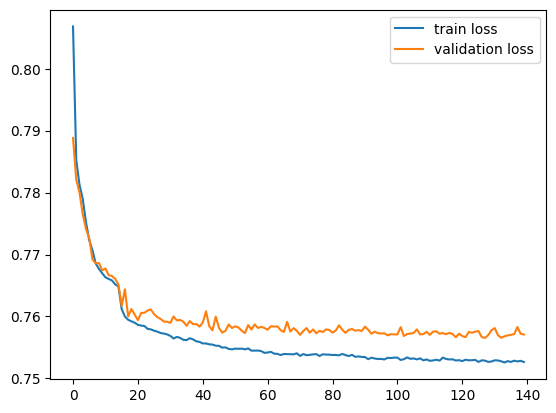

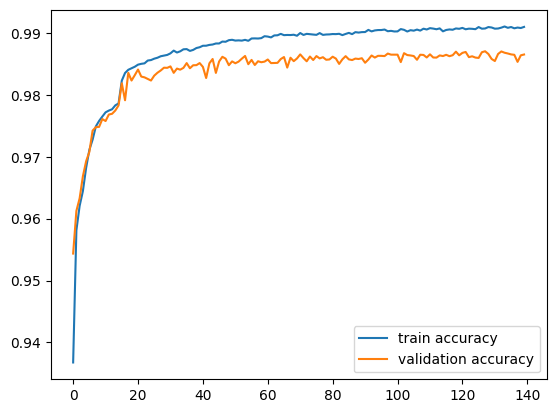

In [4]:
import matplotlib.pyplot as plt

plt.plot(tr_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
#plt.savefig('loss.png', dpi=300)

plt.show()

plt.plot(tr_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
#plt.savefig('accuracy.png', dpi=300)

plt.show()

In [13]:
%load_ext autoreload
%autoreload 2
from TrainAndEvaluate import test_model

# 저장된 데이터 불러오기
test_paths = "./paths/intra_test.csv"

# 데이터셋 생성
test_dataset = ECGDataset(test_paths)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

test_model(model, test_loader, criterion, device, save_plot)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
              precision    recall  f1-score   support

           0      0.988     0.986     0.987    123454
           1      0.978     0.986     0.982    101753
           2      0.996     0.983     0.990     34549
           3      0.994     0.989     0.992     23194

    accuracy                          0.986    282950
   macro avg      0.989     0.986     0.988    282950
weighted avg      0.986     0.986     0.986    282950



,Correct,Incorrect,Total
Normal,121708,1746,123454
AF,100361,1392,101753
AFL,33977,572,34549
Other,22948,246,23194


# K - Fold

In [ ]:
fold_accuracy = []
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda'):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        fold_accuracy.append(val_accuracy)


def evaluate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy


class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

def main():

    np_data = np.load('/content/drive/MyDrive/ECG/training_9s.npy').astype(np.float32)
    label = np.load('/content/drive/MyDrive/ECG/training_9s_label.npy').astype(np.float32)
    X_tensor = torch.tensor(np_data.reshape(np_data.shape[0], 1, np_data.shape[2]), dtype=torch.float32)
    y_tensor = torch.tensor(label, dtype=torch.long)

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(kf.split(X_tensor)):
        print(f"Fold {fold + 1}")
        # Train/test 데이터 나누기
        X_train, X_test = X_tensor[train_index], X_tensor[test_index]
        y_train, y_test = y_tensor[train_index], y_tensor[test_index]

        # 데이터 로더 생성
        train_dataset = ECGDataset(X_train, y_train)
        test_dataset = ECGDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model = MuDANet(num_classes=3)
        model.apply(weights_init)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40, device=device)



if __name__ == '__main__':
    main()
    print(f"\nOverall Accuracy: {np.mean(fold_accuracy):.4f}")